In [26]:
#more rows and columns
options(repr.matrix.max.cols=200, repr.matrix.max.rows=300)

In [2]:
# This is a 16S study of 6 horses that have been treated with an oral antibiotic on day 22-26. 
# They have been sampled before the treatment (day 0-21) but also during the treatment (day 22-26) and after the treatment (day 27-211). 
# The commands below load the data into a phyloseq object (ps) or a summarizedexperiment object (tse)

In [3]:
#seqtab is a count table with countdata with the actual sequence as columnname. Rownames are samplenames
seqtab<-readRDS("seqtab")

In [4]:
#taxa is a table with the sequence as rownames and several columns with taxa information
taxa<-readRDS("taxa")

In [5]:
# The sampledata has the following columns. Samplename (=rowname), 
# Sampling day, Horse, category (before, during, after treatment) 
sampledata<-readRDS("sampledata")

In [6]:
# Your task is to figure out:
# 1. what OTUs would you consider the most affected by the treatment
# 2. After how many days does the microbiome return to pre treatment state using the learning methods from this course
# 3. Explain how you identified the correct day. 

In [7]:
# Below an example how to get the data into phyloseq

In [8]:
library(phyloseq)

In [20]:
ps <- phyloseq(otu_table(seqtab, taxa_are_rows=FALSE), 
               sample_data(sampledata), 
               tax_table(taxa))

In [21]:
ps = rarefy_even_depth(ps)

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

741OTUs were removed because they are no longer 
present in any sample after random subsampling


...



In [22]:
# Advice. Remove very low abundant OTUs
minTotRelAbun = 1e-4
x = taxa_sums(ps)
keepTaxa = (x / sum(x)) > minTotRelAbun
ps.pruned = prune_taxa(keepTaxa, ps)

In [23]:
ps.pruned

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1557 taxa and 198 samples ]
sample_data() Sample Data:       [ 198 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 1557 taxa by 7 taxonomic ranks ]

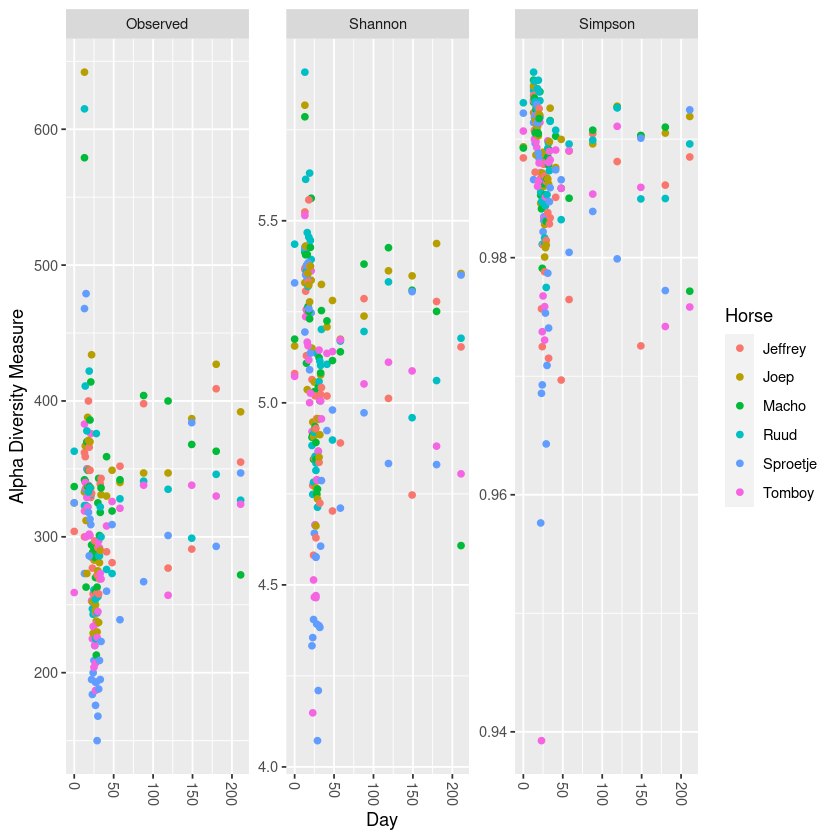

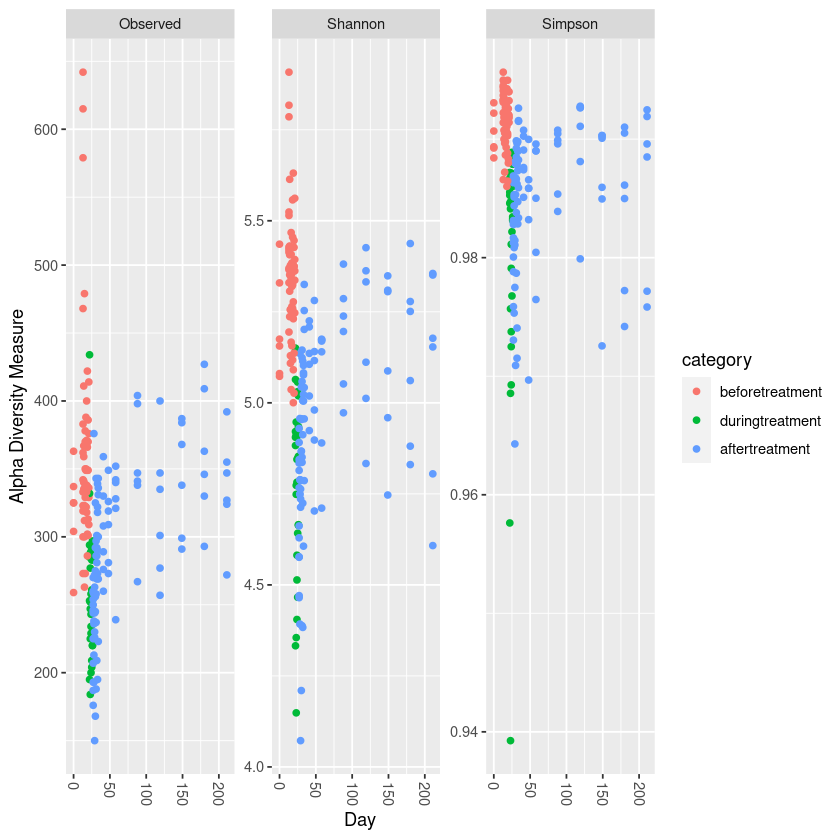

In [27]:
plot_richness(ps.pruned, x="Day", measures=c("Observed", "Shannon", "Simpson"), color="Horse")
plot_richness(ps.pruned, x="Day", measures=c("Observed", "Shannon", "Simpson"), color="category")

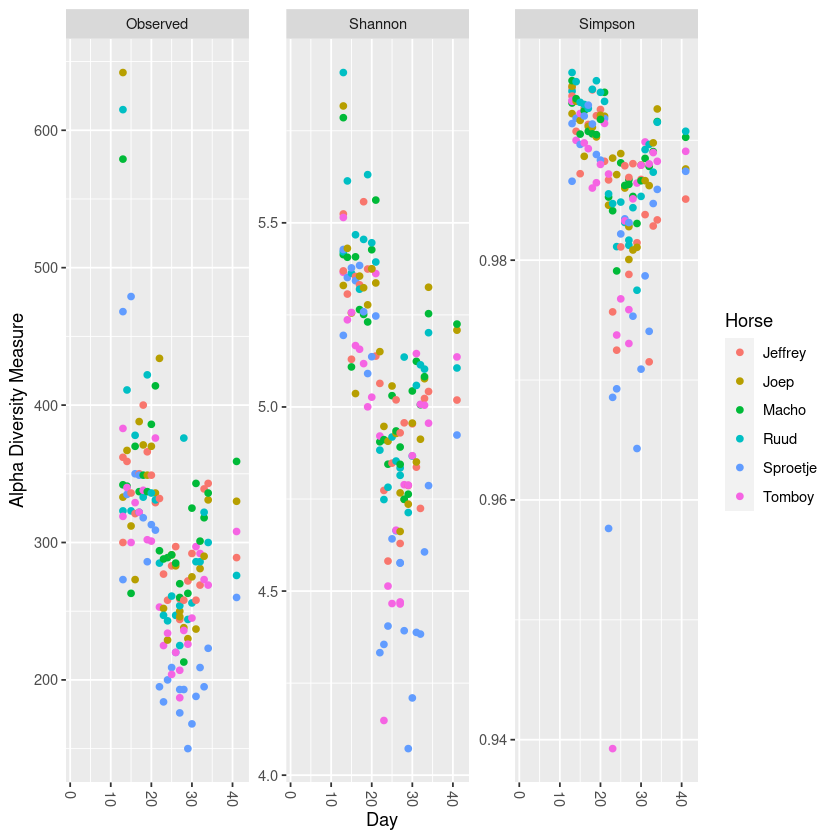

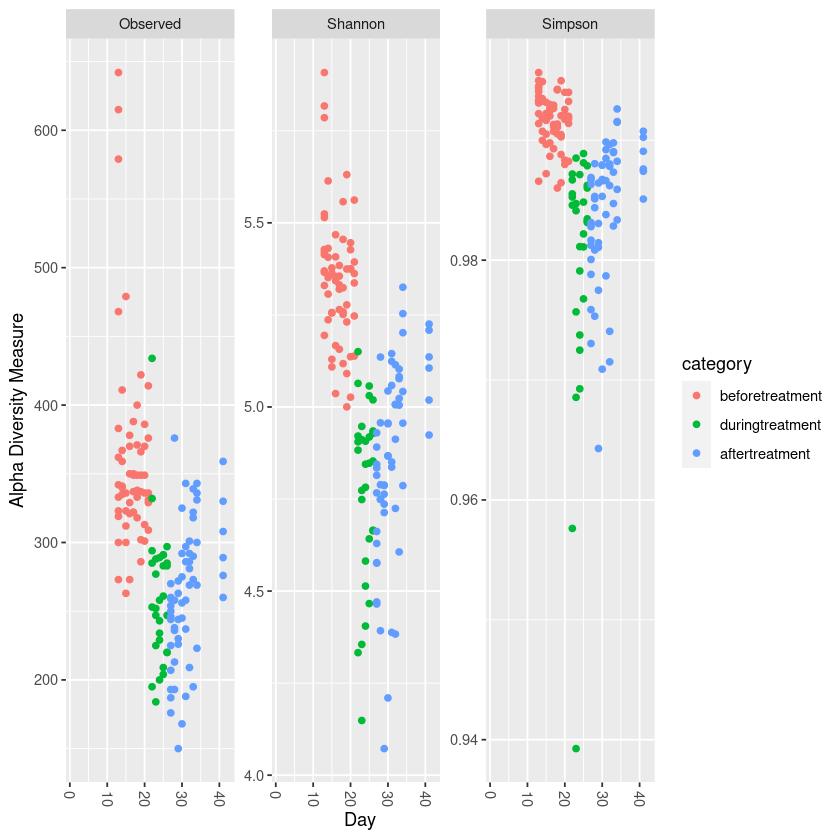

In [29]:
library(ggplot2)
plot_richness(ps.pruned, x="Day", measures=c("Observed", "Shannon", "Simpson"), color="Horse") + xlim(c(1, 42))
plot_richness(ps.pruned, x="Day", measures=c("Observed", "Shannon", "Simpson"), color="category") + xlim(c(1, 42))

In [30]:
ord.nmds.bray <- ordinate(ps.pruned, method="NMDS", distance="bray")

Square root transformation
Wisconsin double standardization
Run 0 stress 0.2041302 
Run 1 stress 0.2072369 
Run 2 stress 0.2085087 
Run 3 stress 0.201163 
... New best solution
... Procrustes: rmse 0.04793343  max resid 0.1511472 
Run 4 stress 0.205939 
Run 5 stress 0.2067927 
Run 6 stress 0.2032657 
Run 7 stress 0.415313 
Run 8 stress 0.20413 
Run 9 stress 0.2051739 
Run 10 stress 0.2022308 
Run 11 stress 0.2083764 
Run 12 stress 0.20413 
Run 13 stress 0.202117 
Run 14 stress 0.202117 
Run 15 stress 0.2021171 
Run 16 stress 0.2041302 
Run 17 stress 0.2052585 
Run 18 stress 0.2043811 
Run 19 stress 0.2077773 
Run 20 stress 0.2021174 
*** No convergence -- monoMDS stopping criteria:
     2: no. of iterations >= maxit
    17: stress ratio > sratmax
     1: scale factor of the gradient < sfgrmin


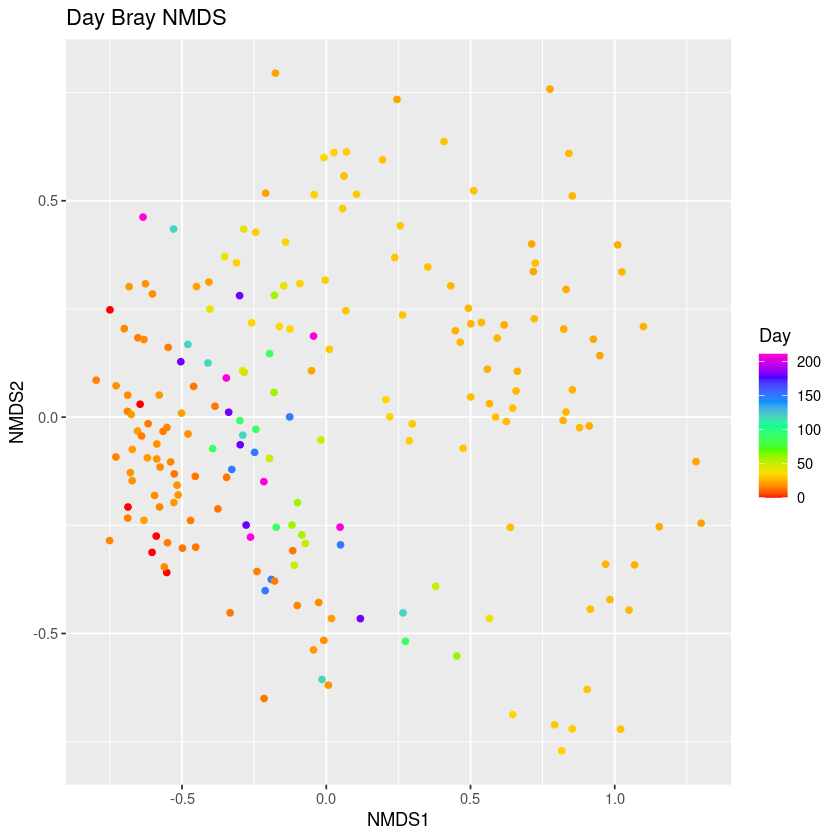

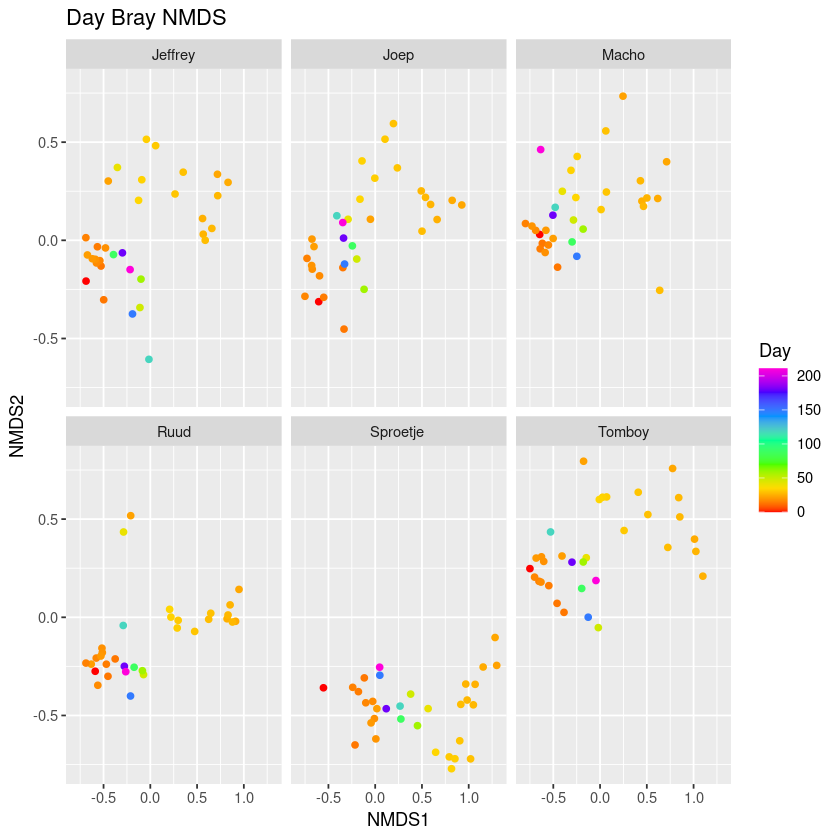

In [32]:
plot_ordination(ps.pruned, ord.nmds.bray, color="Day", title="Day Bray NMDS") + scale_color_gradientn(colours = rainbow(7))
plot_ordination(ps.pruned, ord.nmds.bray, color="Day", title="Day Bray NMDS") + scale_color_gradientn(colours = rainbow(7)) + facet_wrap(~Horse)

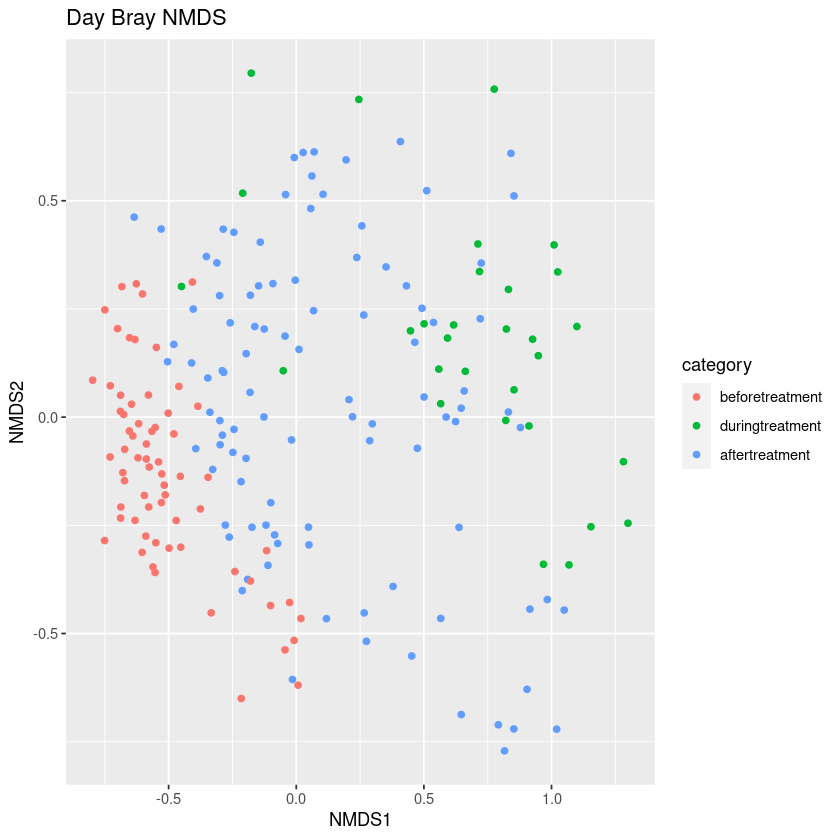

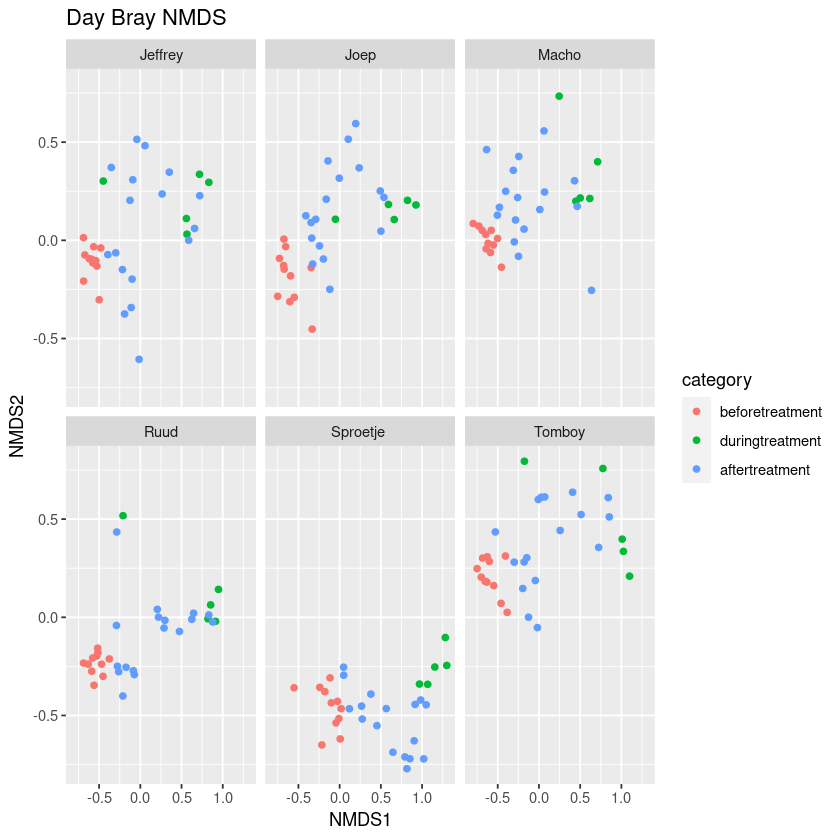

In [33]:
plot_ordination(ps.pruned, ord.nmds.bray, color="category", title="Day Bray NMDS") 
plot_ordination(ps.pruned, ord.nmds.bray, color="category", title="Day Bray NMDS")  + facet_wrap(~Horse)

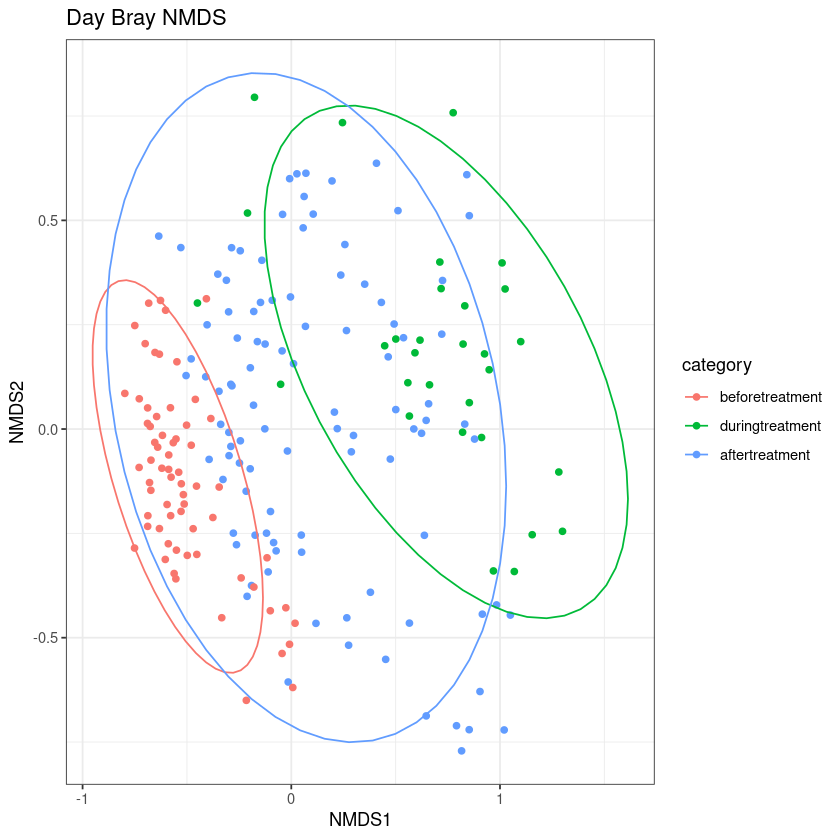

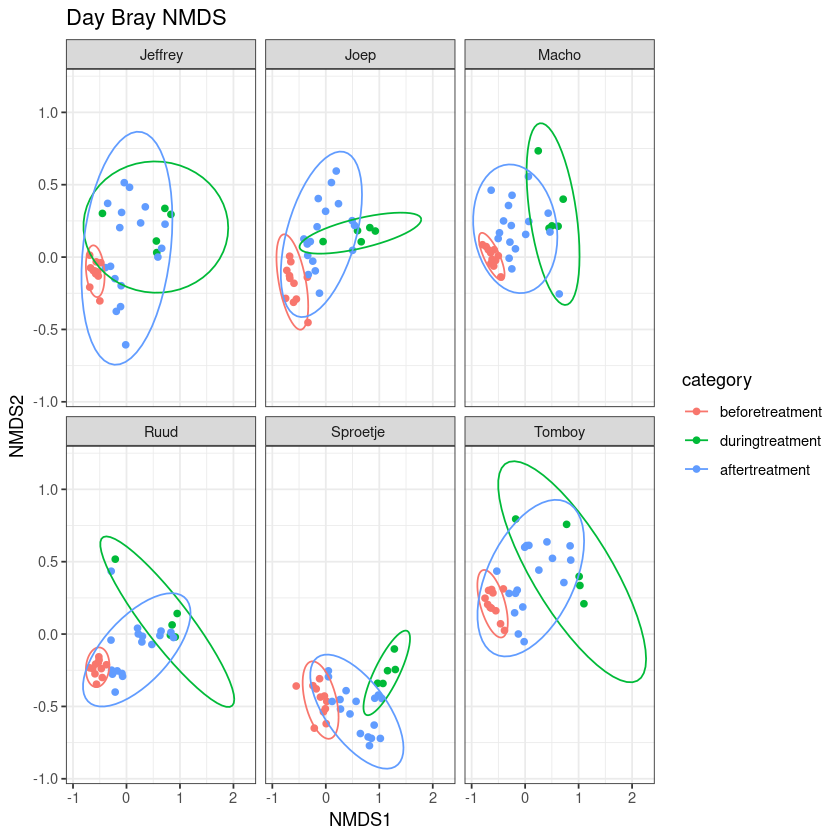

In [41]:
theme_set(theme_bw())
plot_ordination(ps.pruned, ord.nmds.bray, color="category", title="Day Bray NMDS") + stat_ellipse()
plot_ordination(ps.pruned, ord.nmds.bray, color="category", title="Day Bray NMDS")  + facet_wrap(~Horse) + stat_ellipse()

In [34]:
library(vegan) # we will load the vegan library for the permutation anova (PERMANOVA) test called adonis
sampledf <- data.frame(sample_data(ps.pruned)) # create a data frame with sample data  
ps.pruned.bray <- phyloseq::distance(ps.pruned, method = "bray") # generate a distance matrix using Bray distances  
adonis(ps.pruned.bray ~ Horse+Day+category, data = sampledf) # Compare with graphs in nmds.pdf. Does this make sense?
# posthoc
ps.pruned.disper <- betadisper(ps.pruned.bray, sampledf$category)
permutest(ps.pruned.disper)


Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7




Call:
adonis(formula = ps.pruned.bray ~ Horse + Day + category, data = sampledf) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Horse       5     9.656  1.9312  8.1455 0.15007  0.001 ***
Day         1     1.898  1.8983  8.0067 0.02950  0.001 ***
category    2     7.981  3.9903 16.8304 0.12403  0.001 ***
Residuals 189    44.810  0.2371         0.69640           
Total     197    64.345                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
           Df  Sum Sq  Mean Sq     F N.Perm Pr(>F)    
Groups      2 0.22000 0.109998 55.97    999  0.001 ***
Residuals 195 0.38323 0.001965                        
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

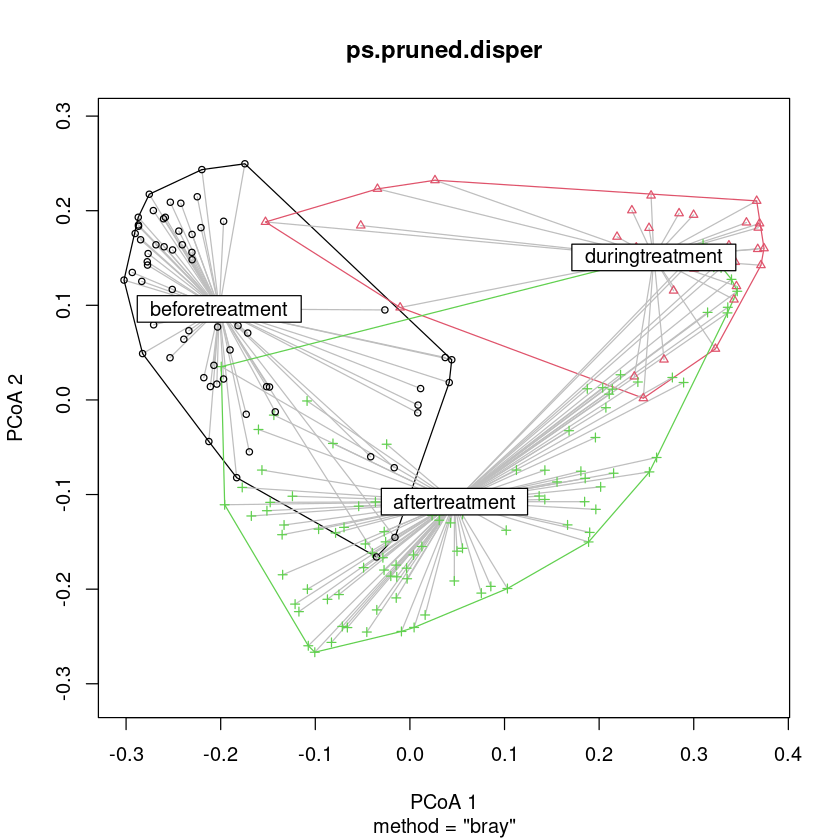

In [35]:
plot(ps.pruned.disper)

In [37]:
library("DESeq2"); packageVersion("DESeq2"); 
diagdds = phyloseq_to_deseq2(ps.pruned, ~ Horse+Day+category) # category as last one. This is the one being tested, the rest is cofactor
# calculate geometric means prior to estimate size factors
gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}
geoMeans = apply(counts(diagdds), 1, gm_mean)
diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")

[1] ‘1.32.0’

converting counts to integer mode

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain cha

In [38]:
res = results(diagdds)
res = res[order(res$padj, na.last=NA), ]
alpha = 0.01
sigtab = res[(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(ps.pruned)[rownames(sigtab), ], "matrix"))
#replace sequences with numbers for better viewing
rownames(sigtab) <- 1:nrow(sigtab)
head(sigtab)

baseMean  log2FoldChange lfcSE     stat      pvalue       padj        
1 17.623644 -7.971949      0.5149246 -15.48178 4.605494e-54 7.170755e-51
2 10.647099 -7.381707      0.4830666 -15.28093 1.024661e-52 7.976985e-50
3 20.998711 -8.335391      0.5985363 -13.92629 4.385437e-44 2.276042e-41
4 24.418355 -7.866035      0.5994071 -13.12303 2.430349e-39 9.460132e-37
5  4.457544 -6.159325      0.4925806 -12.50420 7.081262e-36 2.205105e-33
6 11.738154 -7.727417      0.6508835 -11.87220 1.650748e-32 4.283692e-30
  Kingdom  Phylum        Class         Order           Family            
1 Bacteria Bacteroidetes Bacteroidia   Bacteroidales   F082              
2 Bacteria Fibrobacteres Fibrobacteria Fibrobacterales Fibrobacteraceae  
3 Bacteria Firmicutes    Negativicutes Selenomonadales Acidaminococcaceae
4 Bacteria Bacteroidetes Bacteroidia   Bacteroidales   F082              
5 Bacteria Bacteroidetes Bacteroidia   Bacteroidales   NA                
6 Bacteria Fibrobacteres Fibrobacteria Fibrobacterales Fibrobacteraceae  
  Genus                 Species
1 NA                    NA     
2 Fibrobacter           NA     
3 Phascolarctobacterium NA     
4 NA                    NA     
5 NA                    NA     
6 Fibrobacter           NA

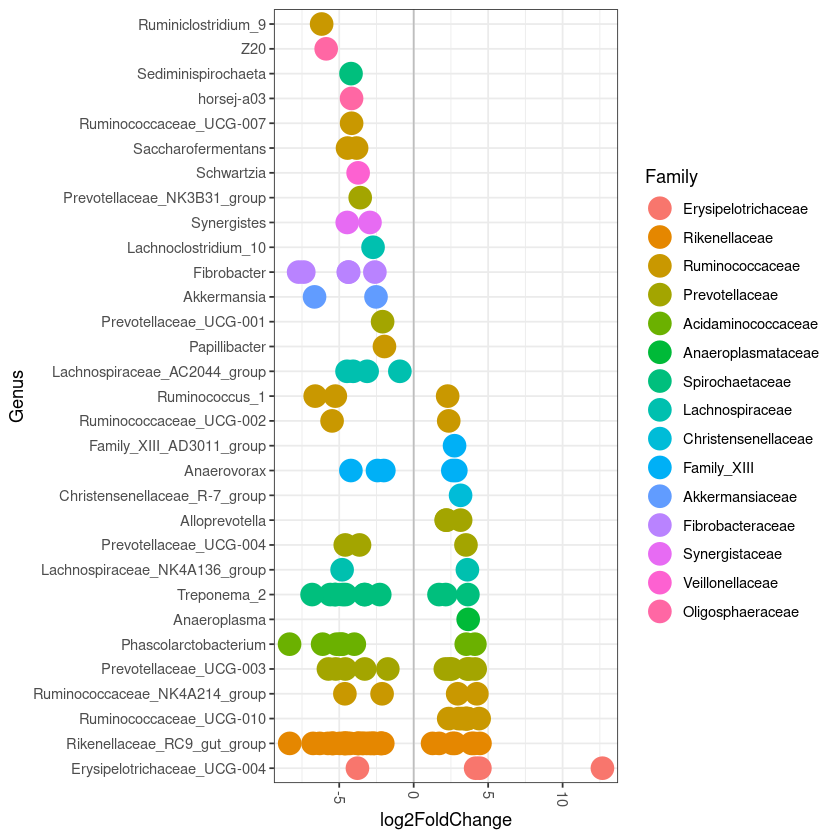

In [39]:
#relatively modest changes?
theme_set(theme_bw())
sigtabgen = subset(sigtab, !is.na(Genus))
# Family order
x = tapply(sigtabgen$log2FoldChange, sigtabgen$Family, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Family = factor(as.character(sigtabgen$Family), levels=names(x))
# Genus order
x = tapply(sigtabgen$log2FoldChange, sigtabgen$Genus, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Genus = factor(as.character(sigtabgen$Genus), levels=names(x))
ggplot(sigtabgen, aes(y=Genus, x=log2FoldChange, color=Family)) + 
  geom_vline(xintercept = 0.0, color = "gray", size = 0.5) +
  geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))

In [40]:
# aha we're only looking at before and after treatment. Thats not our question. 
res

log2 fold change (MLE): category aftertreatment vs beforetreatment 
Wald test p-value: category aftertreatment vs beforetreatment 
DataFrame with 1557 rows and 6 columns
                                                                                                                                                                                                                                                                                                                                                                                                                                                        baseMean
                                                                                                                                                                                                                                                                                                                                                                                             

In [47]:
 ps.beforeduring<-subset_samples(ps.pruned, category!="aftertreatment")

converting counts to integer mode

  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain cha

baseMean  log2FoldChange lfcSE     stat      pvalue       padj        
1  7.405919 -22.308231     1.1378088 -19.60631 1.365923e-85 2.016102e-82
2 16.512302 -29.999504     1.6454082 -18.23226 2.862609e-74 2.112605e-71
3  9.480919 -25.004203     1.4734566 -16.96976 1.374946e-64 6.764732e-62
4  5.533904 -29.999340     1.9612142 -15.29631 8.091584e-53 2.985795e-50
5 38.644215  -8.021231     0.5852025 -13.70676 9.249471e-43 2.730444e-40
6  4.545049 -24.895583     1.8212711 -13.66935 1.547814e-42 3.807622e-40
  Kingdom  Phylum        Class        Order         
1 Bacteria Bacteroidetes Bacteroidia  Bacteroidales 
2 Bacteria Spirochaetes  Spirochaetia Spirochaetales
3 Bacteria Bacteroidetes Bacteroidia  Bacteroidales 
4 Bacteria Bacteroidetes Bacteroidia  Bacteroidales 
5 Bacteria Bacteroidetes Bacteroidia  Bacteroidales 
6 Bacteria Bacteroidetes Bacteroidia  Bacteroidales 
  Family                       Genus                  Species
1 p-251-o5                     NA                     NA     
2 Spirochaetaceae              Treponema_2            NA     
3 Prevotellaceae               Prevotellaceae_UCG-001 NA     
4 Bacteroidales_BS11_gut_group NA                     NA     
5 F082                         NA                     NA     
6 F082                         NA                     NA

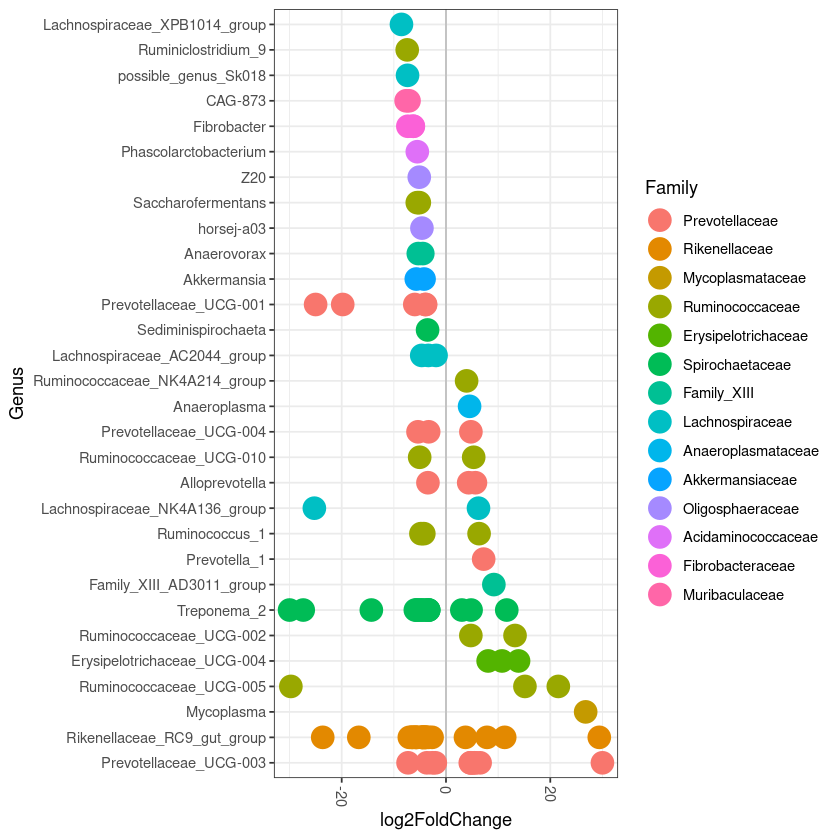

In [50]:
diagdds = phyloseq_to_deseq2(ps.beforeduring, ~ Horse+Day+category) # category as last one. This is the one being tested, the rest is cofactor
# calculate geometric means prior to estimate size factors
gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}
geoMeans = apply(counts(diagdds), 1, gm_mean)
diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
diagdds = DESeq(diagdds, fitType="local")

res = results(diagdds)
res = res[order(res$padj, na.last=NA), ]
alpha = 0.01
sigtab = res[(res$padj < alpha), ]
sigtab = cbind(as(sigtab, "data.frame"), as(tax_table(ps.beforeduring)[rownames(sigtab), ], "matrix"))
#replace sequences with numbers for better viewing
rownames(sigtab) <- 1:nrow(sigtab)
head(sigtab)

#big changes?
theme_set(theme_bw())
sigtabgen = subset(sigtab, !is.na(Genus))
# Family order
x = tapply(sigtabgen$log2FoldChange, sigtabgen$Family, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Family = factor(as.character(sigtabgen$Family), levels=names(x))
# Genus order
x = tapply(sigtabgen$log2FoldChange, sigtabgen$Genus, function(x) max(x))
x = sort(x, TRUE)
sigtabgen$Genus = factor(as.character(sigtabgen$Genus), levels=names(x))
ggplot(sigtabgen, aes(y=Genus, x=log2FoldChange, color=Family)) + 
  geom_vline(xintercept = 0.0, color = "gray", size = 0.5) +
  geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))

In [ ]:
#Time for some machinelearning

In [54]:
#get the features
featurematrix<-otu_table(ps.beforeduring)

In [65]:
#get the classes
featurevector<-sample_data(ps.beforeduring)$category

In [70]:
#imbalanced
tapply(featurevector,featurevector,length)

beforetreatment duringtreatment 
             66              30

In [72]:
library(randomForest)
rf <- randomForest(formula = y ~ x, x=featurematrix,y=as.factor(featurevector), ntree=1000, sampsize=(c(20, 20)))

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine




In [73]:
#get the performance. Nice thing about RF is that it does the 66%/33% OOB split thing on all trees. no need to split our data. 
rf


Call:
 randomForest(x = featurematrix, y = as.factor(featurevector),      ntree = 1000, sampsize = (c(20, 20)), formula = y ~ x) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 39

        OOB estimate of  error rate: 1.04%
Confusion matrix:
                beforetreatment duringtreatment class.error
beforetreatment              66               0  0.00000000
duringtreatment               1              29  0.03333333

In [81]:
as.matrix(rf$predicted)

[,1]           
S2T0A  beforetreatment
S2T0B  beforetreatment
S2T0C  beforetreatment
S2T0D  beforetreatment
S2T0E  beforetreatment
S2T0F  beforetreatment
S2T10A beforetreatment
S2T10B beforetreatment
S2T10C beforetreatment
S2T10D beforetreatment
S2T10E beforetreatment
S2T10F beforetreatment
S2T11A beforetreatment
S2T11B duringtreatment
S2T11C duringtreatment
S2T11D duringtreatment
S2T11E duringtreatment
S2T11F duringtreatment
S2T12A duringtreatment
S2T12B duringtreatment
S2T12C duringtreatment
S2T12D duringtreatment
S2T12E duringtreatment
S2T12F duringtreatment
S2T13A duringtreatment
S2T13B duringtreatment
S2T13C duringtreatment
S2T13D duringtreatment
S2T13E duringtreatment
S2T13F duringtreatment
S2T14A duringtreatment
S2T14B duringtreatment
S2T14C duringtreatment
S2T14D duringtreatment
S2T14E duringtreatment
S2T14F duringtreatment
S2T15A duringtreatment
S2T15B duringtreatment
S2T15C duringtreatment
S2T15D duringtreatment
S2T15E duringtreatment
S2T15F duringtreatment
S2T1A  beforetreatment
S2T1B  beforetreatment
S2T1C  beforetreatment
S2T1D  beforetreatment
S2T1E  beforetreatment
S2T1F  beforetreatment
S2T2A  beforetreatment
S2T2B  beforetreatment
S2T2C  beforetreatment
S2T2D  beforetreatment
S2T2E  beforetreatment
S2T2F  beforetreatment
S2T3A  beforetreatment
S2T3B  beforetreatment
S2T3C  beforetreatment
S2T3D  beforetreatment
S2T3E  beforetreatment
S2T3F  beforetreatment
S2T4A  beforetreatment
S2T4B  beforetreatment
S2T4C  beforetreatment
S2T4D  beforetreatment
S2T4E  beforetreatment
S2T4F  beforetreatment
S2T5A  beforetreatment
S2T5B  beforetreatment
S2T5C  beforetreatment
S2T5D  beforetreatment
S2T5E  beforetreatment
S2T5F  beforetreatment
S2T6A  beforetreatment
S2T6B  beforetreatment
S2T6C  beforetreatment
S2T6D  beforetreatment
S2T6E  beforetreatment
S2T6F  beforetreatment
S2T7A  beforetreatment
S2T7B  beforetreatment
S2T7C  beforetreatment
S2T7D  beforetreatment
S2T7E  beforetreatment
S2T7F  beforetreatment
S2T8A  beforetreatment
S2T8B  beforetreatment
S2T8C  beforetreatment
S2T8D  beforetreatment
S2T8E  beforetreatment
S2T8F  beforetreatment
S2T9A  beforetreatment
S2T9B  beforetreatment
S2T9C  beforetreatment
S2T9D  beforetreatment
S2T9E  beforetreatment
S2T9F  beforetreatment

In [86]:
sample_data(ps.beforeduring)$predicted<-rf$predicted

In [87]:
sample_data(ps.beforeduring)

Day Horse     category        predicted      
S2T0A   0  Jeffrey   beforetreatment beforetreatment
S2T0B   0  Joep      beforetreatment beforetreatment
S2T0C   0  Macho     beforetreatment beforetreatment
S2T0D   0  Ruud      beforetreatment beforetreatment
S2T0E   0  Sproetje  beforetreatment beforetreatment
S2T0F   0  Tomboy    beforetreatment beforetreatment
S2T10A 21  Jeffrey   beforetreatment beforetreatment
S2T10B 21  Joep      beforetreatment beforetreatment
S2T10C 21  Macho     beforetreatment beforetreatment
S2T10D 21  Ruud      beforetreatment beforetreatment
S2T10E 21  Sproetje  beforetreatment beforetreatment
S2T10F 21  Tomboy    beforetreatment beforetreatment
S2T11A 22  Jeffrey   duringtreatment beforetreatment
S2T11B 22  Joep      duringtreatment duringtreatment
S2T11C 22  Macho     duringtreatment duringtreatment
S2T11D 22  Ruud      duringtreatment duringtreatment
S2T11E 22  Sproetje  duringtreatment duringtreatment
S2T11F 22  Tomboy    duringtreatment duringtreatment
S2T12A 23  Jeffrey   duringtreatment duringtreatment
S2T12B 23  Joep      duringtreatment duringtreatment
S2T12C 23  Macho     duringtreatment duringtreatment
S2T12D 23  Ruud      duringtreatment duringtreatment
S2T12E 23  Sproetje  duringtreatment duringtreatment
S2T12F 23  Tomboy    duringtreatment duringtreatment
S2T13A 24  Jeffrey   duringtreatment duringtreatment
S2T13B 24  Joep      duringtreatment duringtreatment
S2T13C 24  Macho     duringtreatment duringtreatment
S2T13D 24  Ruud      duringtreatment duringtreatment
S2T13E 24  Sproetje  duringtreatment duringtreatment
S2T13F 24  Tomboy    duringtreatment duringtreatment
S2T14A 25  Jeffrey   duringtreatment duringtreatment
S2T14B 25  Joep      duringtreatment duringtreatment
S2T14C 25  Macho     duringtreatment duringtreatment
S2T14D 25  Ruud      duringtreatment duringtreatment
S2T14E 25  Sproetje  duringtreatment duringtreatment
S2T14F 25  Tomboy    duringtreatment duringtreatment
S2T15A 26  Jeffrey   duringtreatment duringtreatment
S2T15B 26  Joep      duringtreatment duringtreatment
S2T15C 26  Macho     duringtreatment duringtreatment
S2T15D 26  Ruud      duringtreatment duringtreatment
S2T15E 26  Sproetje  duringtreatment duringtreatment
S2T15F 26  Tomboy    duringtreatment duringtreatment
S2T1A  13  Jeffrey   beforetreatment beforetreatment
S2T1B  13  Joep      beforetreatment beforetreatment
S2T1C  13  Macho     beforetreatment beforetreatment
S2T1D  13  Ruud      beforetreatment beforetreatment
S2T1E  13  Sproetje  beforetreatment beforetreatment
S2T1F  13  Tomboy    beforetreatment beforetreatment
S2T2A  13  Jeffrey   beforetreatment beforetreatment
S2T2B  13  Joep      beforetreatment beforetreatment
S2T2C  13  Macho     beforetreatment beforetreatment
S2T2D  13  Ruud      beforetreatment beforetreatment
S2T2E  13  Sproetje  beforetreatment beforetreatment
S2T2F  13  Tomboy    beforetreatment beforetreatment
S2T3A  14  Jeffrey   beforetreatment beforetreatment
S2T3B  14  Joep      beforetreatment beforetreatment
S2T3C  14  Macho     beforetreatment beforetreatment
S2T3D  14  Ruud      beforetreatment beforetreatment
S2T3E  14  Sproetje  beforetreatment beforetreatment
S2T3F  14  Tomboy    beforetreatment beforetreatment
S2T4A  15  Jeffrey   beforetreatment beforetreatment
S2T4B  15  Joep      beforetreatment beforetreatment
S2T4C  15  Macho     beforetreatment beforetreatment
S2T4D  15  Ruud      beforetreatment beforetreatment
S2T4E  15  Sproetje  beforetreatment beforetreatment
S2T4F  15  Tomboy    beforetreatment beforetreatment
S2T5A  16  Jeffrey   beforetreatment beforetreatment
S2T5B  16  Joep      beforetreatment beforetreatment
S2T5C  16  Macho     beforetreatment beforetreatment
S2T5D  16  Ruud      beforetreatment beforetreatment
S2T5E  16  Sproetje  beforetreatment beforetreatment
S2T5F  16  Tomboy    beforetreatment beforetreatment
S2T6A  17  Jeffrey   beforetreatment beforetreatment
S2T6B  17  Joep      beforetreatment beforetreatment
S2T6C  17  Macho     beforetreat

In [88]:
# first put all data into a matrix for RF
featurematrix_all<-otu_table(ps.pruned)

In [98]:
# we use our model to predict it on all data
votes<-predict(rf, featurematrix_all, type="vote")

In [123]:
votes

beforetreatment duringtreatment
S2T0A  0.934           0.066          
S2T0B  0.875           0.125          
S2T0C  0.934           0.066          
S2T0D  0.930           0.070          
S2T0E  0.940           0.060          
S2T0F  0.857           0.143          
S2T10A 0.897           0.103          
S2T10B 0.961           0.039          
S2T10C 0.938           0.062          
S2T10D 0.910           0.090          
S2T10E 0.810           0.190          
S2T10F 0.690           0.310          
S2T11A 0.256           0.744          
S2T11B 0.175           0.825          
S2T11C 0.090           0.910          
S2T11D 0.179           0.821          
S2T11E 0.060           0.940          
S2T11F 0.180           0.820          
S2T12A 0.026           0.974          
S2T12B 0.008           0.992          
S2T12C 0.016           0.984          
S2T12D 0.027           0.973          
S2T12E 0.025           0.975          
S2T12F 0.028           0.972          
S2T13A 0.025           0.975          
S2T13B 0.018           0.982          
S2T13C 0.021           0.979          
S2T13D 0.014           0.986          
S2T13E 0.017           0.983          
S2T13F 0.028           0.972          
S2T14A 0.079           0.921          
S2T14B 0.026           0.974          
S2T14C 0.067           0.933          
S2T14D 0.048           0.952          
S2T14E 0.027           0.973          
S2T14F 0.034           0.966          
S2T15A 0.082           0.918          
S2T15B 0.069           0.931          
S2T15C 0.085           0.915          
S2T15D 0.064           0.936          
S2T15E 0.069           0.931          
S2T15F 0.065           0.935          
S2T16A 0.195           0.805          
S2T16B 0.216           0.784          
S2T16C 0.211           0.789          
S2T16D 0.113           0.887          
S2T16E 0.127           0.873          
S2T16F 0.172           0.828          
S2T17A 0.175           0.825          
S2T17B 0.223           0.777          
S2T17C 0.206           0.794          
S2T17D 0.138           0.862          
S2T17E 0.137           0.863          
S2T17F 0.147           0.853          
S2T18A 0.211           0.789          
S2T18B 0.301           0.699          
S2T18C 0.334           0.666          
S2T18D 0.097           0.903          
S2T18E 0.230           0.770          
S2T18F 0.169           0.831          
S2T19A 0.324           0.676          
S2T19B 0.377           0.623          
S2T19C 0.455           0.545          
S2T19D 0.253           0.747          
S2T19E 0.313           0.687          
S2T19F 0.342           0.658          
S2T1A  0.965           0.035          
S2T1B  0.802           0.198          
S2T1C  0.941           0.059          
S2T1D  0.906           0.094          
S2T1E  0.800           0.200          
S2T1F  0.851           0.149          
S2T20A 0.368           0.632          
S2T20B 0.330           0.670          
S2T20C 0.436           0.564          
S2T20D 0.311           0.689          
S2T20E 0.333           0.667          
S2T20F 0.411           0.589          
S2T21A 0.450           0.550          
S2T21B 0.445           0.555          
S2T21C 0.435           0.565          
S2T21D 0.391           0.609          
S2T21E 0.354           0.646          
S2T21F 0.416           0.584          
S2T22A 0.499           0.501          
S2T22B 0.530           0.470          
S2T22C 0.573           0.427          
S2T22D 0.378           0.622          
S2T22E 0.312           0.688          
S2T22F 0.494           0.506          
S2T23A 0.508           0.492          
S2T23B 0.608           0.392          
S2T23C 0.556           0.444          
S2T23D 0.411           0.589          
S2T23E 0.313           0.687          
S2T23F 0.507           0.493          
S2T24A 0.586           0.414          
S2T24B 0.599           0.401          
S2T24C 0.644           0.356          
S2T24D 0.393           0.607          
S2T24E 0.345           0.655          
S2T24F 0.505           0.495 

In [124]:
sample_data(ps.pruned)$votesbeforetreatment<-votes[,1]
sample_data(ps.pruned)$votesaftertreatment<-votes[,2]

In [125]:
sample_data(ps.pruned)

Day Horse     category        votesbeforetreatment votesaftertreatment
S2T0A    0 Jeffrey   beforetreatment 0.934                0.066              
S2T0B    0 Joep      beforetreatment 0.875                0.125              
S2T0C    0 Macho     beforetreatment 0.934                0.066              
S2T0D    0 Ruud      beforetreatment 0.930                0.070              
S2T0E    0 Sproetje  beforetreatment 0.940                0.060              
S2T0F    0 Tomboy    beforetreatment 0.857                0.143              
S2T10A  21 Jeffrey   beforetreatment 0.897                0.103              
S2T10B  21 Joep      beforetreatment 0.961                0.039              
S2T10C  21 Macho     beforetreatment 0.938                0.062              
S2T10D  21 Ruud      beforetreatment 0.910                0.090              
S2T10E  21 Sproetje  beforetreatment 0.810                0.190              
S2T10F  21 Tomboy    beforetreatment 0.690                0.310              
S2T11A  22 Jeffrey   duringtreatment 0.256                0.744              
S2T11B  22 Joep      duringtreatment 0.175                0.825              
S2T11C  22 Macho     duringtreatment 0.090                0.910              
S2T11D  22 Ruud      duringtreatment 0.179                0.821              
S2T11E  22 Sproetje  duringtreatment 0.060                0.940              
S2T11F  22 Tomboy    duringtreatment 0.180                0.820              
S2T12A  23 Jeffrey   duringtreatment 0.026                0.974              
S2T12B  23 Joep      duringtreatment 0.008                0.992              
S2T12C  23 Macho     duringtreatment 0.016                0.984              
S2T12D  23 Ruud      duringtreatment 0.027                0.973              
S2T12E  23 Sproetje  duringtreatment 0.025                0.975              
S2T12F  23 Tomboy    duringtreatment 0.028                0.972              
S2T13A  24 Jeffrey   duringtreatment 0.025                0.975              
S2T13B  24 Joep      duringtreatment 0.018                0.982              
S2T13C  24 Macho     duringtreatment 0.021                0.979              
S2T13D  24 Ruud      duringtreatment 0.014                0.986              
S2T13E  24 Sproetje  duringtreatment 0.017                0.983              
S2T13F  24 Tomboy    duringtreatment 0.028                0.972              
S2T14A  25 Jeffrey   duringtreatment 0.079                0.921              
S2T14B  25 Joep      duringtreatment 0.026                0.974              
S2T14C  25 Macho     duringtreatment 0.067                0.933              
S2T14D  25 Ruud      duringtreatment 0.048                0.952              
S2T14E  25 Sproetje  duringtreatment 0.027                0.973              
S2T14F  25 Tomboy    duringtreatment 0.034                0.966              
S2T15A  26 Jeffrey   duringtreatment 0.082                0.918              
S2T15B  26 Joep      duringtreatment 0.069                0.931              
S2T15C  26 Macho     duringtreatment 0.085                0.915              
S2T15D  26 Ruud      duringtreatment 0.064                0.936              
S2T15E  26 Sproetje  duringtreatment 0.069                0.931              
S2T15F  26 Tomboy    duringtreatment 0.065                0.935              
S2T16A  27 Jeffrey   aftertreatment  0.195                0.805              
S2T16B  27 Joep      aftertreatment  0.216                0.784              
S2T16C  27 Macho     aftertreatment  0.211                0.789              
S2T16D  27 Ruud      aftertreatment  0.113                0.887              
S2T16E  27 Sproetje  aftertreatment  0.127                0.873              
S2T16F  27 Tomboy    aftertreatment  0.172                0.828              
S2T17A  27 Jeffrey   aftertreatment  0.175                0.825              
S2T17B  27 Joep      aftertreatment  0.223                0.777              
S2T17C  27 Macho     aftertre

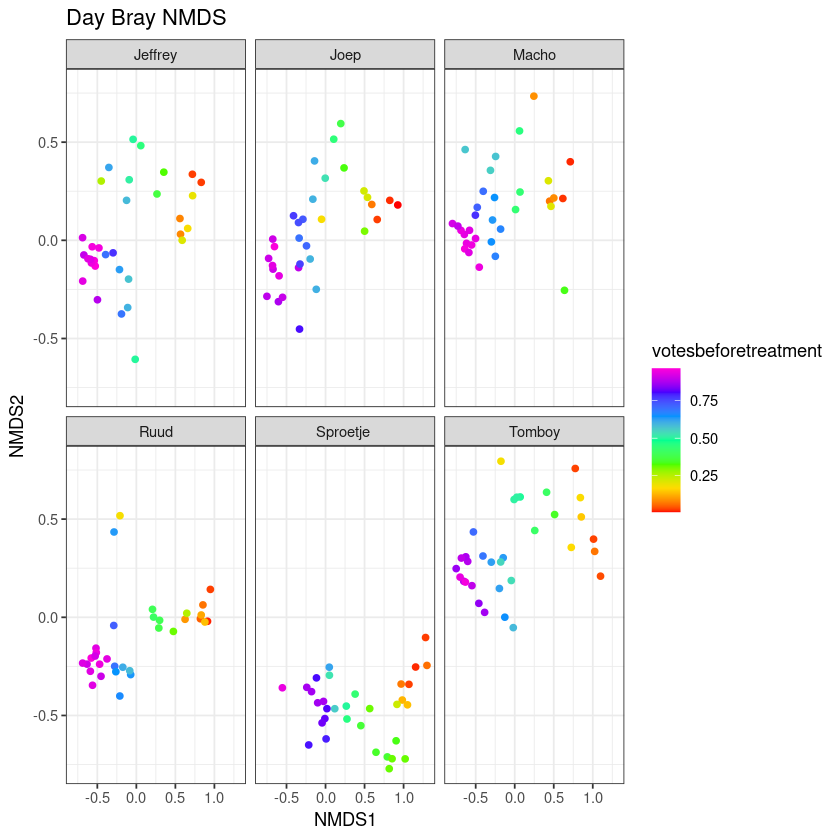

In [126]:
plot_ordination(ps.pruned, ord.nmds.bray, color="votesbeforetreatment", title="Day Bray NMDS") + scale_color_gradientn(colours = rainbow(7)) + facet_wrap(~Horse)

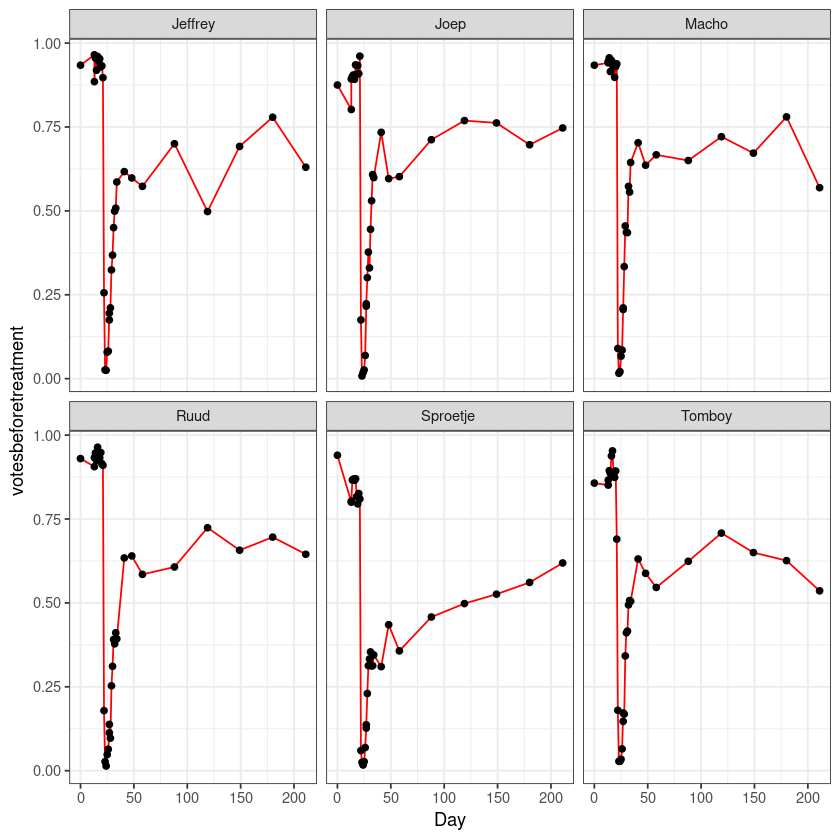

In [134]:
# line plot
ggplot(data=sample_data(ps.pruned), aes(x=Day, y=votesbeforetreatment, group=Horse)) +
  geom_line(color="red")+
  geom_point() + 
  facet_wrap(~Horse)

Warning message:
“Removed 42 row(s) containing missing values (geom_path).”
Warning message:
“Removed 42 rows containing missing values (geom_point).”


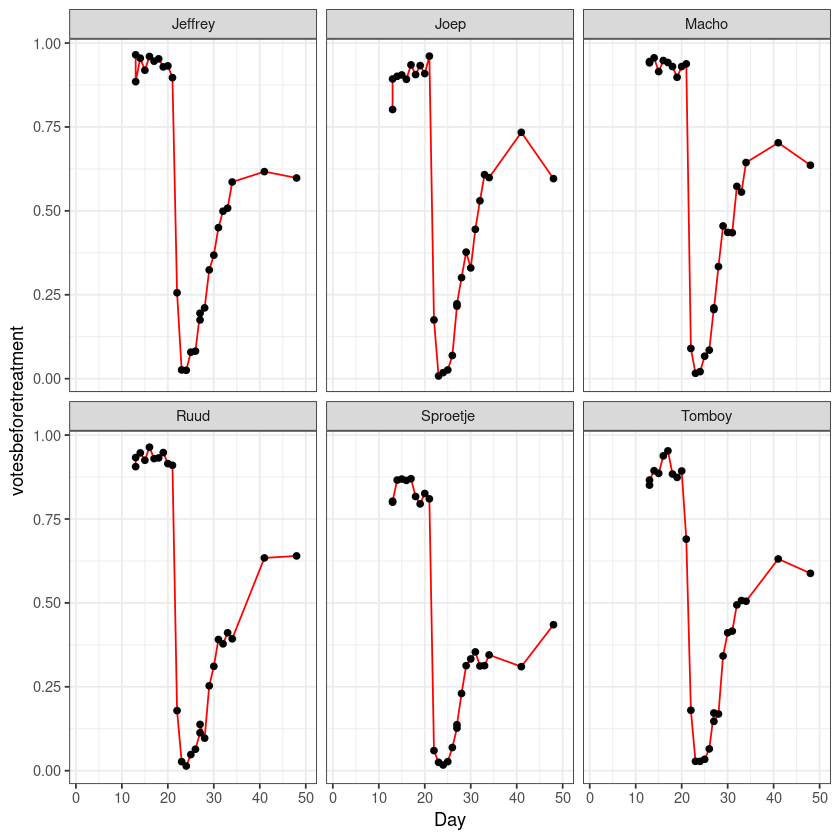

In [135]:
# line plot
ggplot(data=sample_data(ps.pruned), aes(x=Day, y=votesbeforetreatment, group=Horse)) +
  geom_line(color="red")+
  geom_point() + 
  facet_wrap(~Horse) +
  xlim(1,50)

In [136]:
rf$importance

MeanDecreaseGini
CAGTGAGGAATATTGGTCAATGGGCGCAAGCCTGAACCAGCCAAGTCGCGTGAAGGAAGACTGCCCTATGGGTTGTAAACTTCTTTTGCATGGGAATAAAGTGAGCCACGTGTGGCTTTTTGTATGTACCATGCGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGATGGTAAGTCAGTGGTGAAAGTTTGCGGCTCAACCGTAAAATTGCCGTTGAAACTGCCGTTCTTGAGTGCGAGCGAGGTAGGCGGAATGTGCCGTGTAGCGGTGAAATGCATAGATATGGTACAGAACTCCGATTGCGAAGGCAGCCTACCAGTACGCTACTGACGCTGAGGCACGAAAGCGTGGGTATCGAACAGGATTAG       0.046533530     
CAGTGAGGAATATTGGTCAATGGTCGGAAGACTGAACCAGCCATGCCGCGTGAAGGATTAAGGCCCTATGGGTCGTAAACTTCTTTTGTACGGGAGCAATAAGGCTTACGAGTAGGCCGATGAGAGTACCGTACGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTATGGTAAGTCAGCGGTGAAATGTCCACGCTTAACGTGGAACTTGCCGTTGATACTGTCGTACTGGAATTCGGTTGTCGTGGGAGGAATGTGTAGTGTAGCGGTGAAATGCATAGATATTACACAGAACACCGATTGCGAAGGCATCTCACGAAGCCGCGATTGACGCTGAGGCACGAAAGTGCGGGGATCAAACAGGATTAG       0.048632689     
CAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCAAGTAGCGTGAAGGATGACGGCCCTATGGGTTGTAAACTTCTTTTTCCGGGGGATAAAGTGACCCACGTGTGGGTTATTGCAGGTACCCGGTGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGAAATGTAAGTCAGCCGTCAAATCGCGGAGCTCAACTCCGTCCAGCGGTTGAAACTGCGTTTCTTGAGTGCGCAAGAGGCAGGTGGAATTCGAGGTGTAGCGGTGAAATGCTTAGATATCTCGAAGAACTCCGATTGCGAAGGCAGCTTGCTGGGGCGCAACTGACGCTGAGGCTCGAAGGTGCGGGTATCAAACAGGATTAG        0.006056818     
CAGTGAGGAATATTGGTCAATGGACGAGAGTCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTGTACGGGAATAAAGTGACCTACGTGTAGGTTTTTGCATGTACCGTAAGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTGCTTTAAGCGTGTTGTGAAATGTAGGCGCCCAACGTCTGCACTGCAGCGCGAACTGGAGCACTTGAGTACGCAGGAAGTAGGCGGAATTCGTCGTGTAGCGGTGAAATGCTTAGATATGACGAAGAACTCCGATTGGGAAGCCAGCTTACTGTAGCGCCACTGACGCTGATGCTCGAAAGCGTGGGTATCGAACAGGATTAG       0.028224120     
CAGTGGGGAATATTGGACAATGGGGGAAACCCTGATCCAGCGACGCCGCGTGAGTGAAGAAGTATTTCGGTATGTAAAGCTCTATCAGCAAGGAAGAAAATGACGGTACTTGACTAAGAAGCTCCGGCTAAATACGTGCCAGCAGCCGCGGTAATACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAAAGCAAGTCTGAAGTGAAATCCCGGGGCTCAACCCCGGAACTGCTTTGGAAACTGTTTAGCTAGAGTGCAGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACTGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGGATTAG                           0.053001549     
CAGTAGGGAATATTGGGCAATGGAGGCAACTCTGACCCAGCCATGCCGCGTGAAGGAAGACGGCCCTATGGGTTGTAAACTTCTTTTATCGTAGAGTAAACCTGGCCACGTGTGGCCAGCTGAGAGTATACGAGGAATAAGTATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGGGGATACGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGATCGGTAAGTCAGGGGTGAAAAGTTGGGGCTCAACTCCAATCGTGCCTTTGATACTGCCGGACTAGAGTGCGATAGACGTGGCCGGAATGTGATGTGTAGCGGTGAAATGCTTAGATATGTCACAGAACACCGATCGAGAAGTCAGGTCACGAGCTCGCAACTGACGCTCAGGCACGAAAGCGTGGGGATCAAACAGGATTAG       0.012000000     
CAGTAGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCAACGCCACGTGTGGGAAGAAGCATTTCGGTGTGTAAACCACTGTCGTGAAGGAATAATGCCTGGTCTCGGCCAGGTTGAATGTACTTTGAAAGGAAGCACCGGCAAACTTCGTGCCAGCAGCCGCGGTAATACGAGGGGTGCAAGCGTTGTTCGGAATCACTGGGCGTAAAGGGAGCGCAGGCGGAGATGCAAGCGGTCTGTACAATCCCGGGGCCTAACCCCGGACCTGCAGACCGGACTGTTTCTCTTGGATAGCTCAGGGGCTGGCGGAATTCCTGGTGTAGCGGTGGAATGCGTAGAGATCAGGAAGAACACCGATGGCGAAGGCAGCCAGCTGGGGGCTTATCGACGCTCATGCTCGAAAGTGCGGGTAGCAAACAGGATTAG          0.023173109     
CAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCATGTCGCGTGCAGGAATACGGCCCTACGGGTTTTAAACTGCTTTTGCCTGGGGATAAAGTGGCGGACGAGTCCGCTATTGCAGGTACCAGGCGAATAAGGATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCACGCCAAGTCTGCGGTGAAATGTCAGGGCTCAACCTTGGCACTGCCATGGAAACTGGCGAGCTAGAGTGCGTTTGGGGTACATGGAATGTGTGGTGTAGCGGTGAAATGCATAGATATCACACAGAACGCCGATCGCGAAGGCAGTGTACCAAGCCGCAACTGACGCTGAGGCACGAAAGTGCGGGGATCGAACAGGATTAG       0.255428635     
CAGTGAGGAATATTGGTCAATGGGCGCGAGCCTGAACCAGCCAAGTAGCGTGAGGGAAGACGGCCCTACGGGTTGTAAACCTCTTTTGCGCGGGAATAAAGTCAGCCACGTGTGGCTGTTTGCATGTACCGCGGGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGGCCGCCTTTTAAGCGTGTTGTGAAATGCGGGCGCCCAACGTCCGCACTGCAGCGCGAACTGGAGGGCTTGAGTTTGCGGAAAGAAGGCGGAATTCGTTGTGTAGCGGTGA

In [166]:
combined_taxa_importances<-as.data.frame(tax_table(ps.pruned))

In [169]:
combined_taxa_importances$importance <-rf$importance[,1]

In [172]:
combined_taxa_importances

Kingdom 
CAGTGAGGAATATTGGTCAATGGGCGCAAGCCTGAACCAGCCAAGTCGCGTGAAGGAAGACTGCCCTATGGGTTGTAAACTTCTTTTGCATGGGAATAAAGTGAGCCACGTGTGGCTTTTTGTATGTACCATGCGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGATGGTAAGTCAGTGGTGAAAGTTTGCGGCTCAACCGTAAAATTGCCGTTGAAACTGCCGTTCTTGAGTGCGAGCGAGGTAGGCGGAATGTGCCGTGTAGCGGTGAAATGCATAGATATGGTACAGAACTCCGATTGCGAAGGCAGCCTACCAGTACGCTACTGACGCTGAGGCACGAAAGCGTGGGTATCGAACAGGATTAG       Bacteria
CAGTGAGGAATATTGGTCAATGGTCGGAAGACTGAACCAGCCATGCCGCGTGAAGGATTAAGGCCCTATGGGTCGTAAACTTCTTTTGTACGGGAGCAATAAGGCTTACGAGTAGGCCGATGAGAGTACCGTACGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCAAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGTATGGTAAGTCAGCGGTGAAATGTCCACGCTTAACGTGGAACTTGCCGTTGATACTGTCGTACTGGAATTCGGTTGTCGTGGGAGGAATGTGTAGTGTAGCGGTGAAATGCATAGATATTACACAGAACACCGATTGCGAAGGCATCTCACGAAGCCGCGATTGACGCTGAGGCACGAAAGTGCGGGGATCAAACAGGATTAG       Bacteria
CAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCAAGTAGCGTGAAGGATGACGGCCCTATGGGTTGTAAACTTCTTTTTCCGGGGGATAAAGTGACCCACGTGTGGGTTATTGCAGGTACCCGGTGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGAAATGTAAGTCAGCCGTCAAATCGCGGAGCTCAACTCCGTCCAGCGGTTGAAACTGCGTTTCTTGAGTGCGCAAGAGGCAGGTGGAATTCGAGGTGTAGCGGTGAAATGCTTAGATATCTCGAAGAACTCCGATTGCGAAGGCAGCTTGCTGGGGCGCAACTGACGCTGAGGCTCGAAGGTGCGGGTATCAAACAGGATTAG        Bacteria
CAGTGAGGAATATTGGTCAATGGACGAGAGTCTGAACCAGCCAAGTAGCGTGCAGGATGACGGCCCTATGGGTTGTAAACTGCTTTTGTACGGGAATAAAGTGACCTACGTGTAGGTTTTTGCATGTACCGTAAGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTGCTTTAAGCGTGTTGTGAAATGTAGGCGCCCAACGTCTGCACTGCAGCGCGAACTGGAGCACTTGAGTACGCAGGAAGTAGGCGGAATTCGTCGTGTAGCGGTGAAATGCTTAGATATGACGAAGAACTCCGATTGGGAAGCCAGCTTACTGTAGCGCCACTGACGCTGATGCTCGAAAGCGTGGGTATCGAACAGGATTAG       Bacteria
CAGTGGGGAATATTGGACAATGGGGGAAACCCTGATCCAGCGACGCCGCGTGAGTGAAGAAGTATTTCGGTATGTAAAGCTCTATCAGCAAGGAAGAAAATGACGGTACTTGACTAAGAAGCTCCGGCTAAATACGTGCCAGCAGCCGCGGTAATACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAAAGCAAGTCTGAAGTGAAATCCCGGGGCTCAACCCCGGAACTGCTTTGGAAACTGTTTAGCTAGAGTGCAGGAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACTGTAACTGACGTTGAGGCTCGAAAGCGTGGGGAGCAAACAGGATTAG                           Bacteria
CAGTAGGGAATATTGGGCAATGGAGGCAACTCTGACCCAGCCATGCCGCGTGAAGGAAGACGGCCCTATGGGTTGTAAACTTCTTTTATCGTAGAGTAAACCTGGCCACGTGTGGCCAGCTGAGAGTATACGAGGAATAAGTATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGGGGATACGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGATCGGTAAGTCAGGGGTGAAAAGTTGGGGCTCAACTCCAATCGTGCCTTTGATACTGCCGGACTAGAGTGCGATAGACGTGGCCGGAATGTGATGTGTAGCGGTGAAATGCTTAGATATGTCACAGAACACCGATCGAGAAGTCAGGTCACGAGCTCGCAACTGACGCTCAGGCACGAAAGCGTGGGGATCAAACAGGATTAG       Bacteria
CAGTAGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCAACGCCACGTGTGGGAAGAAGCATTTCGGTGTGTAAACCACTGTCGTGAAGGAATAATGCCTGGTCTCGGCCAGGTTGAATGTACTTTGAAAGGAAGCACCGGCAAACTTCGTGCCAGCAGCCGCGGTAATACGAGGGGTGCAAGCGTTGTTCGGAATCACTGGGCGTAAAGGGAGCGCAGGCGGAGATGCAAGCGGTCTGTACAATCCCGGGGCCTAACCCCGGACCTGCAGACCGGACTGTTTCTCTTGGATAGCTCAGGGGCTGGCGGAATTCCTGGTGTAGCGGTGGAATGCGTAGAGATCAGGAAGAACACCGATGGCGAAGGCAGCCAGCTGGGGGCTTATCGACGCTCATGCTCGAAAGTGCGGGTAGCAAACAGGATTAG          Bacteria
CAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCCATGTCGCGTGCAGGAATACGGCCCTACGGGTTTTAAACTGCTTTTGCCTGGGGATAAAGTGGCGGACGAGTCCGCTATTGCAGGTACCAGGCGAATAAGGATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCACGCCAAGTCTGCGGTGAAATGTCAGGGCTCAACCTTGGCACTGCCATGGAAACTGGCGAGCTAGAGTGCGTTTGGGGTACATGGAATGTGTGGTGTAGCGGTGAAATGCATAGATATCACACAGAACGCCGATCGCGAAGGCAGTGTACCAAGCCGCAACTGACGCTGAGGCACGAAAGTGCGGGGATCGAACAGGATTAG       Bacteria
CAGTGAGGAATATTGGTCAATGGGCGCGAGCCTGAACCAGCCAAGTAGCGTGAGGGAAGACGGCCCTACGGGTTGTAAACCTCTTTTGCGCGGGAATAAAGTCAGCCACGTGTGGCTGTTTGCATGTACCGCGGGAATAAGGACCGGCTAATTCCGTGCCAGCAGCCGCGGTAATACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGGCCGCCTTTTAAGCGTGTTGTGAAATGCGGGCGCCCAACGTCCGCACTGCAGCGCGAACTGGAGGGCTTGAGTTTGCGGAAAGAAGGCGGAATTCGTTGTGTAGCGGTGAAATGCTTAGATATGACGAAGAACTCCGATTGCGAAGGCAGCCTTCTGCAGCATTACTGACGCTAAAGCTCGA

In [177]:
#ordering in base R is really really really annoying
combined_taxa_importances[order(combined_taxa_importances[,8]), ]

Kingdom 
CAGTAGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCAACGCCACGTGTGGGAAGAAGCATTTCGGTGTGTAAACCACTGTCGTGAGGGAATAATGCTTGGTTTCGGCCAAGTTGAATGTACCTCGAAAGGAAGCACCGGCAAACTTCGTGCCAGCAGCCGCGGTAATACGAGGGGTGCAAGCGTTGTTCGGAATCACTGGGCGTAAAGGGAGCGCAGGCGGAGATGCAAGCAGTCTGTACAATACCGGGGCCCAACCCCGGACCTGCAGACTGGACTGTTTCTCTTGGATAGTTCAGGGGCAAGCGGAATTCCTGGTGTAGCGGTGGAATGCGTAGAGATCAGGAAGAACACCGATGGCGAAGGCAGCTTGCTGGGGACTTATCGACGCTCATGCTCGAAAGTGCGGGTAGCAAACAGGATTAG          Bacteria
CAGTAGGGAATATTGCACAATGGGGGGAACCCTGATGCAGCAACGCCACGTGTGGGAAGAAGCATTTCGGTGTGTAAACCACTGTCGTGAGGGAATAATGCTCGGTTTCGGCCGAGTTGAATGTACCTCGAAAGGAAGCACCGGCAAACTTCGTGCCAGCAGCCGCGGTAATACGAGGGGTGCAAGCGTTGTTCGGAATCACTGGGCGTAAAGGGAGCGTAGGCGGAGACGCAAGCAGTCTGTACAATACCGGGGCCCAACCCCGGACCTGCAGACTGGACTGTGTCTCTTGGATAGTTCAGGGGCAGGCGGAATTCCTGGTGTAGCGGTGGAATGCGTAGAGATCAGGAAGAACACCGATGGCGAAGGCAGCCTGCTGGGGACTCATCGACGCTGAGGCTCGAAAGTGCGGGTAGCAAACAGGATTAG          Bacteria
CAGTGAGGAATATTGGTCAATGGGCGGAAGCCTGAACCAGCCAAGTCGCGTGCGGGACGAAGGCCCTACGGGTCGTAAACCGCTTTTGTACGGGAATAAAAAACTCCACGCGTGGGGTCTTGTAGGTACCGTAAGAATAAGGATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGGCTGCTAAGTCTCCGGTGAAATGTCAGGGCTCAACCTTGGAATTGCCGGAGATACTGGCGGCCTTGAGAGTGGCGGAGGTATCCGGAATGTGTGGTGTAGCGGTGAAATGCATAGATATCACACAGAACACCGATTGCGAAGGCAGGATACCATACCATATCTGACGCTCAGGCACGAAAGCGTGGGGATCGAACAGGATTAG       Bacteria
CAGTGAGGAATATTGGACAATGGTCGGAAGACTGATCCAGCCATGCCGCGTGAAGGAAGAATGTCCTATGGATTGTAAACTTCTTTTGTACGGGAGCAATAAGGTGTATGCATACACCGATGAGAGTACCGTACGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGAATGCCAAGTCAGCGGTGAAACGCACGCGCTTAACGCGTGACCTGCCGTTGAAACTGGTAGTCTGGAATACGGATGCTGTGGGAGGAATGTGTGGTGTAGCGGTGAAATGCATAGATATCACACAGAACACCGATTGCGAAGGCATCTCACAAATCCGTCATTGACGCTGAGGCACGAAAGTGTGGGGATCAAACAGGATTAG       Bacteria
CAGTGAGGAATATTGGTCAATGGGCGGAAGCCTGAACCAGCCAAGTCGCGTGAAGGATGAAGGTATTATGTATTGTAAACTTCTTTAGCCAGGGGGCAATAAGGCGTACGCGTACGCCGATGAGAGTACCTGGAGAATAAGGATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGCTTTTTAAGTCAGTGGTTAAATCGTGACGCTCAACGTCATCACGCCATTGATACTGGAGAGCTTGATTGCGGTCGAGGTTTGCGGAATTCGTCGTGTAGCGGTGAAATGCATAGATATGACGAAGAACACCGATTGCGTAGGCAGCAGACCAGGCCGTAAATGACGCTCATGCACGAAAGTGCGGGGATCGAACAGGATTAG        Bacteria
CAGTGAGGAATATTGGTCAATGGACGGAAGTCTGAACCAGCCAAGTAGCGTGAAGGATGACGGTATTATGTATTGTAAACTTCTTTTATGGGAGGGTAAAGTGAGCTACGTGTAGTTCATTGCAAGTACCCCATGAATAAGCATCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGGAGATCAAGTCAGCTGTGAAATGTGTATGCTCAACATATGCACTGCAGTTGAAACTGGTTTTCTTGAGTGCGTTAGAAGTGGGTGGAATTTGTGGTGTAGCGGTGAAATGCTTAGATATCACAAAGAACTCCGATTGCGAAGGCAGCTCACTATGCCGCAACTGACGCTGAAGCTCGAAGGTGCGGGTATCGAACAGGATTAG       Bacteria
CAGTAGGGAGTTTTCGGCAATGGGGGAAACCCTGACCGAGCAACGCCGCGTGAATGATGAAGGTCTTCGGATTGTAAAGTTCTGTTATAAGGGAAAAATGATAGGGTGAGGAAATGCTCTCTATTTGATGGTACCTTATTAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGTGAGCAGGCGGCATGGTAAGTTTGAAGTGAAAGCGTGGGGCTTAACCCCATACAGCTTCGAAAACTGCCAGGCTAGAGTGCGGGAGAGGTAAACGGAACTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGTTTACTAGCCCGATACTGACGCTCAGTCACGAAAGCGTGGGGAGCAAATAGGATTAG   Bacteria
CAGTGAGGAATATTGGTCAATGGTCGGAAGACTGAACCAGCCAAGTCGCGTGCAGGAAGACGGTCCTATGGATTGTAAACTGCTTTTGTACGGGAATAAAGTGGGGGACGTGTCCCCCTTGGAATGTACCGTAAGAATAAGGGTCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGACCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGAGGATTAAGTCAGCGGTGAAATTCTCATGCTCAACATGAGAACTGCCATTGATACTGGTCCCCTTGAGAGATGTCGAGGATGGCGGAATGTGATGTGTAGCGGTGAAATGCTTAGATATGTCACAGAACACCGATTGCGAAGGCAGCTGTCCAGAGATCATCTGACGCTCAGGCACGAAAGCATGGGTATCAAACAGGATTAG       Bacteria
CAGTAAGGAATTTTCGGCAATGGGGGAAACCCTGACCGAGCAACGCCGCGTGAGTGTAGAAGGTCTTCGGATTGTAAAGCTCTGTTGTAGAGGAAGAATGCTAAGTATAGGAAATGATATTTAGTTGACGGTACTCTACTAGAAAGTCACGGCTTACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGGGTGCGCAGGCGGTTTGTTAAGTTTGATGTGAAAGCGTTGAGCTCAACTCAATACAGCATCGAATACTGGCAAACTAGAGTGCAGAAGGGGGTAATGGAACTCCATGTGTAGCGGTAAAATGCGTAGATATATGGAAGAACACCAGAGGCGAAGGCGATTACCTGGTCTGTAACTGACGCTCATGC